In [0]:
# Install the PyDrive wrapper & import libraries 
! pip install -U -q PyDrive 

from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 18.6MB/s 


In [0]:
download = drive.CreateFile({'id': '1iJqrsbefohopt9PKhdGkhLgAWguT_-_P'})
download.GetContentFile('train_scene_classification.zip')

!unzip train_scene_classification.zip

Archive:  train_scene_classification.zip
   creating: train/
  inflating: train.csv               
  inflating: train/0.jpg             
  inflating: train/1.jpg             
  inflating: train/10.jpg            
  inflating: train/100.jpg           
  inflating: train/1000.jpg          
  inflating: train/10000.jpg         
  inflating: train/10001.jpg         
  inflating: train/10002.jpg         
  inflating: train/10003.jpg         
  inflating: train/10004.jpg         
  inflating: train/10005.jpg         
  inflating: train/10006.jpg         
  inflating: train/10007.jpg         
  inflating: train/10008.jpg         
  inflating: train/10009.jpg         
  inflating: train/1001.jpg          
  inflating: train/10010.jpg         
  inflating: train/10011.jpg         
  inflating: train/10012.jpg         
  inflating: train/10013.jpg         
  inflating: train/10014.jpg         
  inflating: train/10015.jpg         
  inflating: train/10016.jpg         
  inflating: train/10017.jp

In [0]:
download1 = drive.CreateFile({'id': '1RS7gTtzevKsfhVNXR1HSrqcq5eLMidbH'})
download1.GetContentFile('test_scene_classification.csv')

download2 = drive.CreateFile({'id': '1k3H4stDHxrF8PBA2J5yDkJPTOO8DnAOn'})
download2.GetContentFile('scene_classification_sample_submission.csv')

In [0]:
!ls

adc.json				    train
sample_data				    train.csv
scene_classification_sample_submission.csv  train_scene_classification.zip
test_scene_classification.csv


In [0]:
import pandas as pd 

train_df = pd.read_csv('train.csv')
train_df.head()

,Name,HeadCount
0,10001.jpg,4
1,10002.jpg,4
2,10003.jpg,2
3,10004.jpg,3
4,10006.jpg,4


In [0]:
train_df.shape

(17034, 2)

In [0]:
train_df['label'].unique()

array([0, 4, 5, 1, 2, 3])

In [0]:
test_df = pd.read_csv('test_scene_classification.csv')
test_df.head()

,image_name
0,3.jpg
1,5.jpg
2,6.jpg
3,11.jpg
4,14.jpg


In [0]:
test_df.shape

(7301, 1)

In [0]:
sub_df = pd.read_csv('scene_classification_sample_submission.csv')
sub_df.head()

,image_name,label
0,3.jpg,0
1,5.jpg,0
2,6.jpg,0
3,11.jpg,0
4,14.jpg,0


In [0]:
sub_df.shape

(7301, 2)

In [0]:
sub_df.tail()

,image_name,label
7296,24326.jpg,0
7297,24327.jpg,0
7298,24330.jpg,0
7299,24331.jpg,0
7300,24333.jpg,0


In [0]:
import os 

train_files = os.listdir('train')

In [0]:
len(train_files)

24335

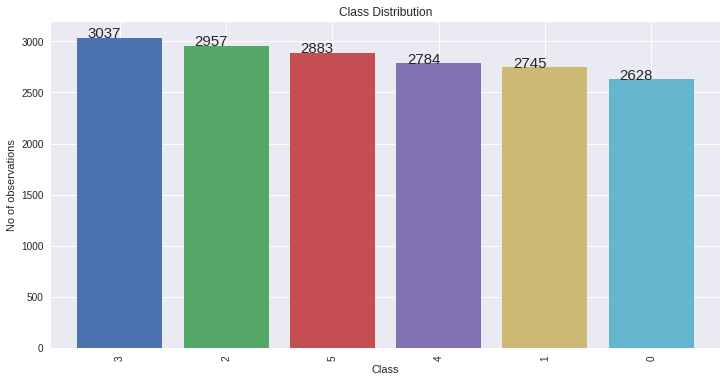

<Figure size 576x396 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt 

plt.subplots(figsize = (12, 6))
ax = train_df['label'].value_counts().plot(kind = 'bar', width = 0.8)
ax.set_xlabel('Class')
ax.set_ylabel('No of observations')
ax.set_title('Class Distribution')
for p in ax.patches:
  ax.annotate(format(p.get_height()),(p.get_x()+0.1,p.get_height()), fontsize=15)
plt.show()
plt.savefig('class_distribution.png')

In [0]:
!ls

adc.json				    test_scene_classification.csv
class_distribution.png			    train
sample_data				    train.csv
scene_classification_sample_submission.csv  train_scene_classification.zip


**Importing Libraries**

In [0]:
import os 
import keras 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 
import random

from keras.models import Sequential 
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers 
from keras import metrics 
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


**Plotting Sample Images **

In [0]:
TRAIN_DIR = 'train'

In [0]:
def getClassLabel(class_code):
  labels = {0: 'Buildings', 1 : 'Forest', 2 : 'Glacier', 3 : 'Mountain', 4 : 'Sea', 5 : 'Street' }
  return labels[class_code]

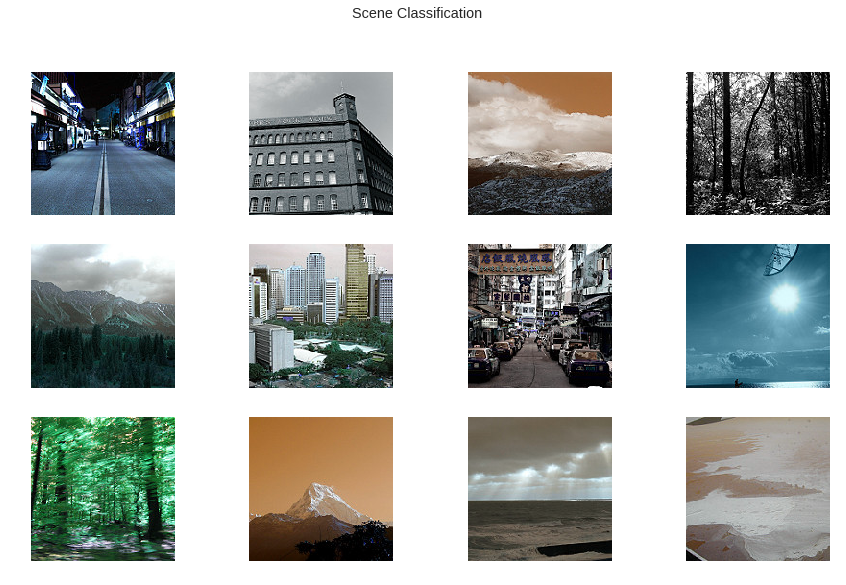

In [0]:
sample_normal = random.sample(os.listdir('train'), 12)
f, ax = plt.subplots(3, 4, figsize = (15, 9))

for i in range(0, 12):
  im = cv2.imread('train/'+sample_normal[i])
  ax[i//4, i%4].imshow(im)
  
  ax[i//4, i%4].axis('off')
f.suptitle('Scene Classification')
plt.show()

In [0]:
train_df.dtypes

image_name    object
label          int64
dtype: object

In [0]:
train_df['label'] = train_df['label'].apply(str)

In [0]:
print(train_df.dtypes)

image_name    object
label         object
dtype: object


**Loading Image Training Data**

In [0]:
datagen = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.20,
    shear_range = 0.2, 
    zoom_range = 0.2,
    horizontal_flip = True
)


In [0]:
train_generator = datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = "train/",
    x_col = 'image_name',
    y_col = 'label',
    subset = 'training',
    seed = 42,
    batch_size = 32, 
    shuffle = True, 
    class_mode = "categorical", 
    target_size = (150, 150) 
)

Found 13628 images belonging to 6 classes.


In [0]:
valid_generator = datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = "train/",
    x_col = 'image_name',
    y_col = 'label',
    subset = 'validation',
    seed = 42,
    batch_size = 32,
    shuffle = True, 
    class_mode = 'categorical',
    target_size = (150, 150)
)

Found 3406 images belonging to 6 classes.


In [0]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df, 
    directory = 'train/',
    x_col = 'image_name',
    y_col = None,
    batch_size = 32, 
    seed = 42,
    shuffle = False, 
    class_mode = None,
    target_size = (150, 150)
)

Found 7301 images.


In [0]:
7301/3

2433.6666666666665

**Build The Model**

In [0]:
model = Sequential()
model.add(Conv2D(200, (3, 3), padding = 'same', input_shape = (150, 150, 3)))
model.add(Activation('relu'))
model.add(Conv2D(180, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (5, 5)))
#model.add(Dropout(0.25))

model.add(Conv2D(180, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(140, (3, 3)))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(100, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(50, (3, 3)))
model.add(Activation('relu'))
#model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size = (5, 5)))

model.add(Flatten())
model.add(Dense(180))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation = 'softmax'))

model.compile(optimizers.Adam(lr = 0.0001), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [0]:
#model.compile(optimizers.rmsprop(lr = 0.001, decay = 1e-6), loss = 'categorical_crossentropy', metrics = ['accuracy'])

**Fitting Model**

In [0]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size


history = model.fit_generator(generator = train_generator, 
                   steps_per_epoch = STEP_SIZE_TRAIN,
                   validation_data = valid_generator, 
                   validation_steps = STEP_SIZE_VALID,
                   epochs = 20)

Epoch 1/20
425/425 [==============================] - 252s 593ms/step - loss: 0.5559 - acc: 0.8147 - val_loss: 0.4767 - val_acc: 0.8388
Epoch 2/20
425/425 [==============================] - 252s 592ms/step - loss: 0.5430 - acc: 0.8161 - val_loss: 0.4820 - val_acc: 0.8331
Epoch 3/20
425/425 [==============================] - 251s 592ms/step - loss: 0.5161 - acc: 0.8279 - val_loss: 0.4769 - val_acc: 0.8414
Epoch 4/20
425/425 [==============================] - 253s 594ms/step - loss: 0.5098 - acc: 0.8325 - val_loss: 0.4623 - val_acc: 0.8384
Epoch 5/20
425/425 [==============================] - 252s 593ms/step - loss: 0.4983 - acc: 0.8390 - val_loss: 0.4542 - val_acc: 0.8435
Epoch 6/20
425/425 [==============================] - 253s 594ms/step - loss: 0.4802 - acc: 0.8405 - val_loss: 0.4381 - val_acc: 0.8545
Epoch 7/20
425/425 [==============================] - 253s 595ms/step - loss: 0.4561 - acc: 0.8479 - val_loss: 0.4401 - val_acc: 0.8515
Epoch 8/20
425/425 [============================

In [0]:
4:37

In [0]:
7301/32

228.15625

In [0]:
print(STEP_SIZE_TEST)
print(228*32)

228
7296


**Evaluate The Model**

In [0]:
model.evaluate_generator(generator = valid_generator, steps = STEP_SIZE_VALID )

[0.51998118313375, 0.8180201541550709]

In [0]:
#model.save_weights('model1.h5')

**Results**

In [0]:
import matplotlib.pyplot as plt
def results(history):
    # Accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc']); plt.plot(history.history['val_acc']);
    plt.title('model accuracy'); plt.ylabel('accuracy');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
    plt.title('model loss'); plt.ylabel('loss');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
    plt.show()
    
    return plt

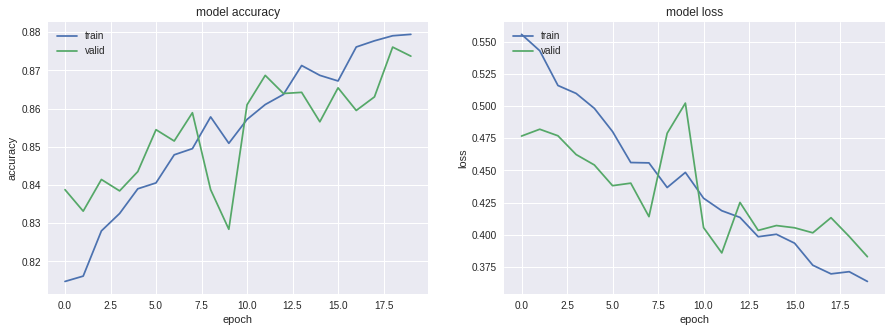

In [0]:
plt = results(history)

In [0]:
plt.savefig('model1_results.png')

<Figure size 576x396 with 0 Axes>

**Submission**

In [0]:
test_generator.reset()
pred = model.predict_generator(test_generator, steps = 7301/32, verbose = 0)

In [0]:
predicted_class_indices = np.argmax(pred, axis = 1)
predicted_class_indices.shape

(7301,)

In [0]:
labels = (train_generator.class_indices)
labels

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}

In [0]:
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [0]:
filenames = test_generator.filenames
filenames = filenames
results = pd.DataFrame({"image_name" : filenames, "label" : predictions})
results.to_csv("results.csv", index = False)


In [0]:
results = pd.read_csv("results.csv")
results.head()

,image_name,label
0,3.jpg,5
1,5.jpg,0
2,6.jpg,4
3,11.jpg,4
4,14.jpg,5


In [0]:
results.shape

(7301, 2)

In [0]:
!ls

adc.json		sample_data
class_distribution.png	scene_classification_sample_submission.csv
model1.h5		test_scene_classification.csv
model1_results.png	train
model.h5		train.csv
results.csv		train_scene_classification.zip


In [0]:
from google.colab import files

#files.download('results.csv')
files.download('model1.h5')
files.download('model1_results.png')
files.download('class_distribution.png')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 51084, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil